In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])
plt.rcParams["figure.figsize"] = (8, 4)

# Dataset 

In [10]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

#data_path = "../thesis/dataset/EthenT/"
#postfix = "EthenT"
#dim = 72
#N_ELECTRONS = 16
#basis = "6-311++g**"

data_path = "../butadien/data/400/"
postfix = "400_6-311++g**"
dim = 130
N_ELECTRONS = 30
basis = "6-311++g**"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#[S, P] = np.load()
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

#index = np.load(join(data_path, "index" + postfix + ".npy"))


#ind = int(0.8 * len(S))
ind = 0

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])
#molecules = ([], molecules)

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test = S.reshape(-1, dim, dim)
#p_test = S.reshape(-1, dim, dim)

In [12]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    #train=(None, None),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

In [13]:
from pyscf.scf import hf
h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

# Utilities 

In [14]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd(p_guess, p_conv))
    return np.array(p_embedded)


In [15]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

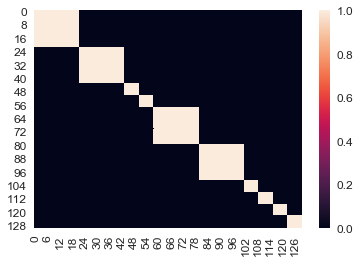

In [16]:
import seaborn as sns

sns.heatmap(mask.astype("int"))

In [17]:
np.mean(np.abs(p_test.flatten() - embedd_batch(p_test).flatten()))

0.0

In [18]:
from pyscf.scf import hf
def fock_from_density_batch(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

In [19]:
from SCFInitialGuess.utilities.dataset import density_from_fock

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)


# GWH 

In [20]:
from pyscf.scf import hf

p_gwh = np.array([ 
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [21]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities, mf_initializer

print(make_results_str(measure_all_quantities(
    p_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 15:10:29: Iteration calculation: 0
[ ] 2019-01-07 15:10:38: Iteration calculation: 1
[ ] 2019-01-07 15:10:45: Iteration calculation: 2
[ ] 2019-01-07 15:10:55: Iteration calculation: 3
[ ] 2019-01-07 15:11:04: Iteration calculation: 4
[ ] 2019-01-07 15:11:12: Iteration calculation: 5
[ ] 2019-01-07 15:11:21: Iteration calculation: 6
[ ] 2019-01-07 15:11:30: Iteration calculation: 7
[ ] 2019-01-07 15:11:39: Iteration calculation: 8
[ ] 2019-01-07 15:11:47: Iteration calculation: 9
[ ] 2019-01-07 15:11:57: Iteration calculation: 10
[ ] 2019-01-07 15:12:06: Iteration calculation: 11
[ ] 2019-01-07 15:12:14: Iteration calculation: 12
[ ] 2019-01-07 15:12:24: Iteration calculation: 13
[ ] 2019-01-07 15:12:32: Iteration calculation: 14
[ ] 2019-01-07 15:12:41: Iteration calculation: 15
[ ] 2019-01-07 15:12:50: Iteration calculation: 16
[ ] 2019-01-07 15:12:59: Iteration calculation: 17
[ ] 2019-01-07 15:13:08: Iteration calculation: 18
[ ] 2019-01-07 15:13:17: Iteration calcul

[ ] 2019-01-07 15:34:57: Iteration calculation: 160
[ ] 2019-01-07 15:35:09: Iteration calculation: 161
[ ] 2019-01-07 15:35:18: Iteration calculation: 162
[ ] 2019-01-07 15:35:29: Iteration calculation: 163
[ ] 2019-01-07 15:35:38: Iteration calculation: 164
[ ] 2019-01-07 15:35:47: Iteration calculation: 165
[ ] 2019-01-07 15:35:55: Iteration calculation: 166
[ ] 2019-01-07 15:36:04: Iteration calculation: 167
[ ] 2019-01-07 15:36:13: Iteration calculation: 168
[ ] 2019-01-07 15:36:25: Iteration calculation: 169
[ ] 2019-01-07 15:36:34: Iteration calculation: 170
[ ] 2019-01-07 15:36:43: Iteration calculation: 171
[ ] 2019-01-07 15:36:52: Iteration calculation: 172
[ ] 2019-01-07 15:37:01: Iteration calculation: 173
[ ] 2019-01-07 15:37:13: Iteration calculation: 174
[ ] 2019-01-07 15:37:22: Iteration calculation: 175
[ ] 2019-01-07 15:37:32: Iteration calculation: 176
[ ] 2019-01-07 15:37:42: Iteration calculation: 177
[ ] 2019-01-07 15:37:51: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 16:00:47: Iteration calculation: 318
[ ] 2019-01-07 16:00:56: Iteration calculation: 319
[ ] 2019-01-07 16:01:07: Iteration calculation: 320
[ ] 2019-01-07 16:01:17: Iteration calculation: 321
[ ] 2019-01-07 16:01:25: Iteration calculation: 322
[ ] 2019-01-07 16:01:37: Iteration calculation: 323
[ ] 2019-01-07 16:01:46: Iteration calculation: 324
[ ] 2019-01-07 16:01:57: Iteration calculation: 325
[ ] 2019-01-07 16:02:06: Iteration calculation: 326
[ ] 2019-01-07 16:02:18: Iteration calculation: 327
[ ] 2019-01-07 16:02:27: Iteration calculation: 328
[ ] 2019-01-07 16:02:36: Iteration calculation: 329
[ ] 2019-01-07 16:02:48: Iteration calculation: 330
[ ] 2019-01-07 16:02:57: Iteration calculation: 331
[ ] 2019-01-07 16:03:09: Iteration calculation: 332
[ ] 2019-01-07 16:03:17: Iteration calculation: 333
[ ] 2019-01-07 16:03:26: Iteration calculation: 334
[ ] 2019-01-07 16:03:36: Iteration calculation: 335
[ ] 2019-01-07 16:03:47: Iteration calculation: 336
[ ] 2019-01-

/home/jo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/jo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Embedded GWH 

In [22]:
p_embedded_gwh = embedd_batch(p_gwh)

In [23]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 16:33:40: Iteration calculation: 0
[ ] 2019-01-07 16:33:43: Iteration calculation: 1
[ ] 2019-01-07 16:33:46: Iteration calculation: 2
[ ] 2019-01-07 16:33:49: Iteration calculation: 3
[ ] 2019-01-07 16:33:52: Iteration calculation: 4
[ ] 2019-01-07 16:33:57: Iteration calculation: 5
[ ] 2019-01-07 16:34:01: Iteration calculation: 6
[ ] 2019-01-07 16:34:04: Iteration calculation: 7
[ ] 2019-01-07 16:34:07: Iteration calculation: 8
[ ] 2019-01-07 16:34:10: Iteration calculation: 9
[ ] 2019-01-07 16:34:13: Iteration calculation: 10
[ ] 2019-01-07 16:34:18: Iteration calculation: 11
[ ] 2019-01-07 16:34:21: Iteration calculation: 12
[ ] 2019-01-07 16:34:24: Iteration calculation: 13
[ ] 2019-01-07 16:34:27: Iteration calculation: 14
[ ] 2019-01-07 16:34:31: Iteration calculation: 15
[ ] 2019-01-07 16:34:33: Iteration calculation: 16
[ ] 2019-01-07 16:34:36: Iteration calculation: 17
[ ] 2019-01-07 16:34:39: Iteration calculation: 18
[ ] 2019-01-07 16:34:43: Iteration calcul

[ ] 2019-01-07 16:42:51: Iteration calculation: 160
[ ] 2019-01-07 16:42:55: Iteration calculation: 161
[ ] 2019-01-07 16:42:58: Iteration calculation: 162
[ ] 2019-01-07 16:43:02: Iteration calculation: 163
[ ] 2019-01-07 16:43:05: Iteration calculation: 164
[ ] 2019-01-07 16:43:08: Iteration calculation: 165
[ ] 2019-01-07 16:43:11: Iteration calculation: 166
[ ] 2019-01-07 16:43:15: Iteration calculation: 167
[ ] 2019-01-07 16:43:20: Iteration calculation: 168
[ ] 2019-01-07 16:43:23: Iteration calculation: 169
[ ] 2019-01-07 16:43:26: Iteration calculation: 170
[ ] 2019-01-07 16:43:29: Iteration calculation: 171
[ ] 2019-01-07 16:43:32: Iteration calculation: 172
[ ] 2019-01-07 16:43:37: Iteration calculation: 173
[ ] 2019-01-07 16:43:41: Iteration calculation: 174
[ ] 2019-01-07 16:43:44: Iteration calculation: 175
[ ] 2019-01-07 16:43:47: Iteration calculation: 176
[ ] 2019-01-07 16:43:50: Iteration calculation: 177
[ ] 2019-01-07 16:43:53: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 16:51:39: Iteration calculation: 318
[ ] 2019-01-07 16:51:42: Iteration calculation: 319
[ ] 2019-01-07 16:51:45: Iteration calculation: 320
[ ] 2019-01-07 16:51:50: Iteration calculation: 321
[ ] 2019-01-07 16:51:54: Iteration calculation: 322
[ ] 2019-01-07 16:51:57: Iteration calculation: 323
[ ] 2019-01-07 16:51:59: Iteration calculation: 324
[ ] 2019-01-07 16:52:02: Iteration calculation: 325
[ ] 2019-01-07 16:52:06: Iteration calculation: 326
[ ] 2019-01-07 16:52:11: Iteration calculation: 327
[ ] 2019-01-07 16:52:14: Iteration calculation: 328
[ ] 2019-01-07 16:52:17: Iteration calculation: 329
[ ] 2019-01-07 16:52:20: Iteration calculation: 330
[ ] 2019-01-07 16:52:24: Iteration calculation: 331
[ ] 2019-01-07 16:52:27: Iteration calculation: 332
[ ] 2019-01-07 16:52:30: Iteration calculation: 333
[ ] 2019-01-07 16:52:33: Iteration calculation: 334
[ ] 2019-01-07 16:52:38: Iteration calculation: 335
[ ] 2019-01-07 16:52:42: Iteration calculation: 336
[ ] 2019-01-

In [24]:
51/1001

0.05094905094905095

# Embedded GWH + 1 Iteration

In [25]:
f_embedded_gwh = fock_from_density_batch(p_embedded_gwh)
p_embedded_gwh_test = density_from_fock_batch(f_embedded_gwh)

In [26]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 17:25:03: Iteration calculation: 0
[ ] 2019-01-07 17:25:07: Iteration calculation: 1
[ ] 2019-01-07 17:25:10: Iteration calculation: 2
[ ] 2019-01-07 17:25:13: Iteration calculation: 3
[ ] 2019-01-07 17:25:16: Iteration calculation: 4
[ ] 2019-01-07 17:25:19: Iteration calculation: 5
[ ] 2019-01-07 17:25:24: Iteration calculation: 6
[ ] 2019-01-07 17:25:27: Iteration calculation: 7
[ ] 2019-01-07 17:25:31: Iteration calculation: 8
[ ] 2019-01-07 17:25:33: Iteration calculation: 9
[ ] 2019-01-07 17:25:36: Iteration calculation: 10
[ ] 2019-01-07 17:25:39: Iteration calculation: 11
[ ] 2019-01-07 17:25:44: Iteration calculation: 12
[ ] 2019-01-07 17:25:47: Iteration calculation: 13
[ ] 2019-01-07 17:25:50: Iteration calculation: 14
[ ] 2019-01-07 17:25:53: Iteration calculation: 15
[ ] 2019-01-07 17:25:56: Iteration calculation: 16
[ ] 2019-01-07 17:25:58: Iteration calculation: 17
[ ] 2019-01-07 17:26:01: Iteration calculation: 18
[ ] 2019-01-07 17:26:04: Iteration calcul

[ ] 2019-01-07 17:34:15: Iteration calculation: 160
[ ] 2019-01-07 17:34:19: Iteration calculation: 161
[ ] 2019-01-07 17:34:22: Iteration calculation: 162
[ ] 2019-01-07 17:34:26: Iteration calculation: 163
[ ] 2019-01-07 17:34:29: Iteration calculation: 164
[ ] 2019-01-07 17:34:33: Iteration calculation: 165
[ ] 2019-01-07 17:34:36: Iteration calculation: 166
[ ] 2019-01-07 17:34:40: Iteration calculation: 167
[ ] 2019-01-07 17:34:44: Iteration calculation: 168
[ ] 2019-01-07 17:34:47: Iteration calculation: 169
[ ] 2019-01-07 17:34:50: Iteration calculation: 170
[ ] 2019-01-07 17:34:53: Iteration calculation: 171
[ ] 2019-01-07 17:34:56: Iteration calculation: 172
[ ] 2019-01-07 17:34:59: Iteration calculation: 173
[ ] 2019-01-07 17:35:02: Iteration calculation: 174
[ ] 2019-01-07 17:35:06: Iteration calculation: 175
[ ] 2019-01-07 17:35:10: Iteration calculation: 176
[ ] 2019-01-07 17:35:14: Iteration calculation: 177
[ ] 2019-01-07 17:35:17: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 17:43:11: Iteration calculation: 318
[ ] 2019-01-07 17:43:14: Iteration calculation: 319
[ ] 2019-01-07 17:43:17: Iteration calculation: 320
[ ] 2019-01-07 17:43:21: Iteration calculation: 321
[ ] 2019-01-07 17:43:24: Iteration calculation: 322
[ ] 2019-01-07 17:43:27: Iteration calculation: 323
[ ] 2019-01-07 17:43:30: Iteration calculation: 324
[ ] 2019-01-07 17:43:33: Iteration calculation: 325
[ ] 2019-01-07 17:43:35: Iteration calculation: 326
[ ] 2019-01-07 17:43:38: Iteration calculation: 327
[ ] 2019-01-07 17:43:43: Iteration calculation: 328
[ ] 2019-01-07 17:43:47: Iteration calculation: 329
[ ] 2019-01-07 17:43:50: Iteration calculation: 330
[ ] 2019-01-07 17:43:54: Iteration calculation: 331
[ ] 2019-01-07 17:43:58: Iteration calculation: 332
[ ] 2019-01-07 17:44:01: Iteration calculation: 333
[ ] 2019-01-07 17:44:05: Iteration calculation: 334
[ ] 2019-01-07 17:44:09: Iteration calculation: 335
[ ] 2019-01-07 17:44:13: Iteration calculation: 336
[ ] 2019-01-

# SAD 

In [27]:
from pyscf.scf import hf

p_sad = np.array([ 
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

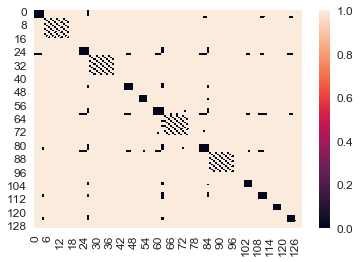

In [28]:
sns.heatmap((abs(p_sad[0]) < 1e-12).astype("int"))

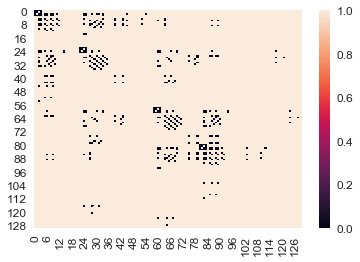

In [29]:
sns.heatmap((abs(p_gwh[0]) < 0.05).astype("int"))

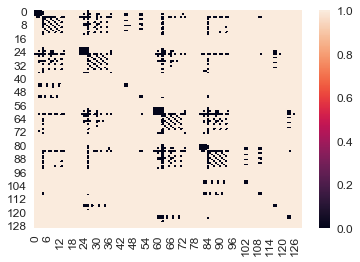

In [30]:
sns.heatmap((abs(p_test[30]) < 0.05).astype("int"))

In [31]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities, mf_initializer

print(make_results_str(measure_all_quantities(
    p_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 18:06:58: Iteration calculation: 0
[ ] 2019-01-07 18:07:01: Iteration calculation: 1
[ ] 2019-01-07 18:07:05: Iteration calculation: 2
[ ] 2019-01-07 18:07:08: Iteration calculation: 3
[ ] 2019-01-07 18:07:11: Iteration calculation: 4
[ ] 2019-01-07 18:07:14: Iteration calculation: 5
[ ] 2019-01-07 18:07:17: Iteration calculation: 6
[ ] 2019-01-07 18:07:22: Iteration calculation: 7
[ ] 2019-01-07 18:07:26: Iteration calculation: 8
[ ] 2019-01-07 18:07:29: Iteration calculation: 9
[ ] 2019-01-07 18:07:32: Iteration calculation: 10
[ ] 2019-01-07 18:07:35: Iteration calculation: 11
[ ] 2019-01-07 18:07:39: Iteration calculation: 12
[ ] 2019-01-07 18:07:42: Iteration calculation: 13
[ ] 2019-01-07 18:07:45: Iteration calculation: 14
[ ] 2019-01-07 18:07:48: Iteration calculation: 15
[ ] 2019-01-07 18:07:51: Iteration calculation: 16
[ ] 2019-01-07 18:07:54: Iteration calculation: 17
[ ] 2019-01-07 18:07:58: Iteration calculation: 18
[ ] 2019-01-07 18:08:02: Iteration calcul

[ ] 2019-01-07 18:16:05: Iteration calculation: 160
[ ] 2019-01-07 18:16:09: Iteration calculation: 161
[ ] 2019-01-07 18:16:13: Iteration calculation: 162
[ ] 2019-01-07 18:16:17: Iteration calculation: 163
[ ] 2019-01-07 18:16:20: Iteration calculation: 164
[ ] 2019-01-07 18:16:23: Iteration calculation: 165
[ ] 2019-01-07 18:16:26: Iteration calculation: 166
[ ] 2019-01-07 18:16:29: Iteration calculation: 167
[ ] 2019-01-07 18:16:34: Iteration calculation: 168
[ ] 2019-01-07 18:16:38: Iteration calculation: 169
[ ] 2019-01-07 18:16:41: Iteration calculation: 170
[ ] 2019-01-07 18:16:45: Iteration calculation: 171
[ ] 2019-01-07 18:16:48: Iteration calculation: 172
[ ] 2019-01-07 18:16:51: Iteration calculation: 173
[ ] 2019-01-07 18:16:54: Iteration calculation: 174
[ ] 2019-01-07 18:16:57: Iteration calculation: 175
[ ] 2019-01-07 18:17:02: Iteration calculation: 176
[ ] 2019-01-07 18:17:06: Iteration calculation: 177
[ ] 2019-01-07 18:17:09: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 18:25:10: Iteration calculation: 318
[ ] 2019-01-07 18:25:13: Iteration calculation: 319
[ ] 2019-01-07 18:25:16: Iteration calculation: 320
[ ] 2019-01-07 18:25:20: Iteration calculation: 321
[ ] 2019-01-07 18:25:23: Iteration calculation: 322
[ ] 2019-01-07 18:25:27: Iteration calculation: 323
[ ] 2019-01-07 18:25:30: Iteration calculation: 324
[ ] 2019-01-07 18:25:33: Iteration calculation: 325
[ ] 2019-01-07 18:25:36: Iteration calculation: 326
[ ] 2019-01-07 18:25:39: Iteration calculation: 327
[ ] 2019-01-07 18:25:44: Iteration calculation: 328
[ ] 2019-01-07 18:25:48: Iteration calculation: 329
[ ] 2019-01-07 18:25:51: Iteration calculation: 330
[ ] 2019-01-07 18:25:54: Iteration calculation: 331
[ ] 2019-01-07 18:25:57: Iteration calculation: 332
[ ] 2019-01-07 18:26:01: Iteration calculation: 333
[ ] 2019-01-07 18:26:06: Iteration calculation: 334
[ ] 2019-01-07 18:26:09: Iteration calculation: 335
[ ] 2019-01-07 18:26:13: Iteration calculation: 336
[ ] 2019-01-

In [32]:
47/1001

0.04695304695304695

# Embedded zeros 

In [33]:
p_embedded_zeros = embedd_batch(np.zeros(p_test.shape))

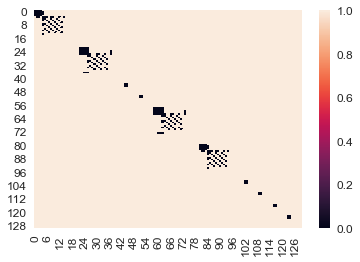

In [34]:
sns.heatmap((abs(p_embedded_zeros[0]) < 0.05).astype("int"))

In [35]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_zeros,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 18:48:18: Iteration calculation: 0
[ ] 2019-01-07 18:48:28: Iteration calculation: 1
[ ] 2019-01-07 18:48:39: Iteration calculation: 2
[ ] 2019-01-07 18:48:48: Iteration calculation: 3
[ ] 2019-01-07 18:49:00: Iteration calculation: 4
[ ] 2019-01-07 18:49:11: Iteration calculation: 5
[ ] 2019-01-07 18:49:22: Iteration calculation: 6
[ ] 2019-01-07 18:49:31: Iteration calculation: 7
[ ] 2019-01-07 18:49:43: Iteration calculation: 8
[ ] 2019-01-07 18:49:53: Iteration calculation: 9
[ ] 2019-01-07 18:50:03: Iteration calculation: 10
[ ] 2019-01-07 18:50:15: Iteration calculation: 11
[ ] 2019-01-07 18:50:25: Iteration calculation: 12
[ ] 2019-01-07 18:50:36: Iteration calculation: 13
[ ] 2019-01-07 18:50:46: Iteration calculation: 14
[ ] 2019-01-07 18:50:57: Iteration calculation: 15
[ ] 2019-01-07 18:51:06: Iteration calculation: 16
[ ] 2019-01-07 18:51:18: Iteration calculation: 17
[ ] 2019-01-07 18:51:29: Iteration calculation: 18
[ ] 2019-01-07 18:51:39: Iteration calcul

[ ] 2019-01-07 19:14:17: Iteration calculation: 160
[ ] 2019-01-07 19:14:28: Iteration calculation: 161
[ ] 2019-01-07 19:14:38: Iteration calculation: 162
[ ] 2019-01-07 19:14:49: Iteration calculation: 163
[ ] 2019-01-07 19:15:00: Iteration calculation: 164
[ ] 2019-01-07 19:15:11: Iteration calculation: 165
[ ] 2019-01-07 19:15:20: Iteration calculation: 166
[ ] 2019-01-07 19:15:32: Iteration calculation: 167
[ ] 2019-01-07 19:15:42: Iteration calculation: 168
[ ] 2019-01-07 19:15:53: Iteration calculation: 169
[ ] 2019-01-07 19:16:02: Iteration calculation: 170
[ ] 2019-01-07 19:16:14: Iteration calculation: 171
[ ] 2019-01-07 19:16:25: Iteration calculation: 172
[ ] 2019-01-07 19:16:34: Iteration calculation: 173
[ ] 2019-01-07 19:16:46: Iteration calculation: 174
[ ] 2019-01-07 19:16:57: Iteration calculation: 175
[ ] 2019-01-07 19:17:07: Iteration calculation: 176
[ ] 2019-01-07 19:17:18: Iteration calculation: 177
[ ] 2019-01-07 19:17:27: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 19:42:13: Iteration calculation: 318
[ ] 2019-01-07 19:42:25: Iteration calculation: 319
[ ] 2019-01-07 19:42:36: Iteration calculation: 320
[ ] 2019-01-07 19:42:47: Iteration calculation: 321
[ ] 2019-01-07 19:42:57: Iteration calculation: 322
[ ] 2019-01-07 19:43:08: Iteration calculation: 323
[ ] 2019-01-07 19:43:19: Iteration calculation: 324
[ ] 2019-01-07 19:43:29: Iteration calculation: 325
[ ] 2019-01-07 19:43:40: Iteration calculation: 326
[ ] 2019-01-07 19:43:51: Iteration calculation: 327
[ ] 2019-01-07 19:44:01: Iteration calculation: 328
[ ] 2019-01-07 19:44:10: Iteration calculation: 329
[ ] 2019-01-07 19:44:22: Iteration calculation: 330
[ ] 2019-01-07 19:44:33: Iteration calculation: 331
[ ] 2019-01-07 19:44:44: Iteration calculation: 332
[ ] 2019-01-07 19:44:54: Iteration calculation: 333
[ ] 2019-01-07 19:45:04: Iteration calculation: 334
[ ] 2019-01-07 19:45:16: Iteration calculation: 335
[ ] 2019-01-07 19:45:27: Iteration calculation: 336
[ ] 2019-01-

# Embedded zeros + 1 Iteration? 

In [36]:
f_embedded_zeros = fock_from_density_batch(p_embedded_zeros)
p_embedded_zeros_test = density_from_fock_batch(f_embedded_zeros,)

In [37]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    p_embedded_zeros_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 20:25:36: Iteration calculation: 0
[ ] 2019-01-07 20:25:45: Iteration calculation: 1
[ ] 2019-01-07 20:25:55: Iteration calculation: 2
[ ] 2019-01-07 20:26:06: Iteration calculation: 3
[ ] 2019-01-07 20:26:17: Iteration calculation: 4
[ ] 2019-01-07 20:26:28: Iteration calculation: 5
[ ] 2019-01-07 20:26:39: Iteration calculation: 6
[ ] 2019-01-07 20:26:49: Iteration calculation: 7
[ ] 2019-01-07 20:26:58: Iteration calculation: 8
[ ] 2019-01-07 20:27:10: Iteration calculation: 9
[ ] 2019-01-07 20:27:21: Iteration calculation: 10
[ ] 2019-01-07 20:27:32: Iteration calculation: 11
[ ] 2019-01-07 20:27:42: Iteration calculation: 12
[ ] 2019-01-07 20:27:52: Iteration calculation: 13
[ ] 2019-01-07 20:28:01: Iteration calculation: 14
[ ] 2019-01-07 20:28:13: Iteration calculation: 15
[ ] 2019-01-07 20:28:24: Iteration calculation: 16
[ ] 2019-01-07 20:28:34: Iteration calculation: 17
[ ] 2019-01-07 20:28:44: Iteration calculation: 18
[ ] 2019-01-07 20:28:55: Iteration calcul

[ ] 2019-01-07 20:51:30: Iteration calculation: 160
[ ] 2019-01-07 20:51:40: Iteration calculation: 161
[ ] 2019-01-07 20:51:51: Iteration calculation: 162
[ ] 2019-01-07 20:52:02: Iteration calculation: 163
[ ] 2019-01-07 20:52:12: Iteration calculation: 164
[ ] 2019-01-07 20:52:23: Iteration calculation: 165
[ ] 2019-01-07 20:52:34: Iteration calculation: 166
[ ] 2019-01-07 20:52:44: Iteration calculation: 167
[ ] 2019-01-07 20:52:55: Iteration calculation: 168
[ ] 2019-01-07 20:53:06: Iteration calculation: 169
[ ] 2019-01-07 20:53:16: Iteration calculation: 170
[ ] 2019-01-07 20:53:27: Iteration calculation: 171
[ ] 2019-01-07 20:53:36: Iteration calculation: 172
[ ] 2019-01-07 20:53:48: Iteration calculation: 173
[ ] 2019-01-07 20:53:59: Iteration calculation: 174
[ ] 2019-01-07 20:54:09: Iteration calculation: 175
[ ] 2019-01-07 20:54:20: Iteration calculation: 176
[ ] 2019-01-07 20:54:31: Iteration calculation: 177
[ ] 2019-01-07 20:54:40: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 21:19:28: Iteration calculation: 318
[ ] 2019-01-07 21:19:38: Iteration calculation: 319
[ ] 2019-01-07 21:19:47: Iteration calculation: 320
[ ] 2019-01-07 21:19:59: Iteration calculation: 321
[ ] 2019-01-07 21:20:08: Iteration calculation: 322
[ ] 2019-01-07 21:20:20: Iteration calculation: 323
[ ] 2019-01-07 21:20:31: Iteration calculation: 324
[ ] 2019-01-07 21:20:40: Iteration calculation: 325
[ ] 2019-01-07 21:20:52: Iteration calculation: 326
[ ] 2019-01-07 21:21:02: Iteration calculation: 327
[ ] 2019-01-07 21:21:11: Iteration calculation: 328
[ ] 2019-01-07 21:21:20: Iteration calculation: 329
[ ] 2019-01-07 21:21:32: Iteration calculation: 330
[ ] 2019-01-07 21:21:43: Iteration calculation: 331
[ ] 2019-01-07 21:21:53: Iteration calculation: 332
[ ] 2019-01-07 21:22:04: Iteration calculation: 333
[ ] 2019-01-07 21:22:13: Iteration calculation: 334
[ ] 2019-01-07 21:22:25: Iteration calculation: 335
[ ] 2019-01-07 21:22:35: Iteration calculation: 336
[ ] 2019-01-

#  

In [38]:
77/1001

0.07692307692307693

# Embedded GWH w/ Self-Overlap 

In [39]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask_self_overlap = np.zeros((dim, dim))

current_dim_i = 0
for i, atom_i in enumerate(mol.species):
    
    
    # calculate block range
    index_start_i = current_dim_i
    current_dim_i += N_BASIS[basis][atom_i] 
    index_end_i = current_dim_i
    
    # calculate logical vector
    L_i = np.arange(dim)
    L_i = np.logical_and(index_start_i <= L_i, L_i < index_end_i)
    
    current_dim_j = 0
    for j, atom_j in enumerate(mol.species):
        

        #print(str(i) + ", " + str(j))    
        #print(str(atom_i) + ", " + str(atom_j))
        
        # calculate block range
        index_start_j = current_dim_j
        current_dim_j += N_BASIS[basis][atom_j] 
        index_end_j = current_dim_j

        if i == j:
            continue
        
        if atom_i == atom_j:
            # calculate logical vector
            L_j = np.arange(dim)
            L_j = np.logical_and(index_start_j <= L_j, L_j < index_end_j)


            m = np.logical_and.outer(L_i, L_j)
            
            mask_self_overlap = np.logical_or(mask_self_overlap, m)
    
#mask

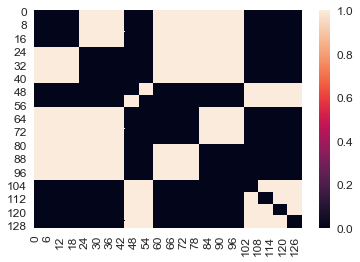

In [40]:
import seaborn as sns

sns.heatmap(mask_self_overlap.astype("int"))

In [41]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_self_ovlp(x, y):
    p = x.copy()
    p[mask_self_overlap] = (y.copy())[mask_self_overlap]
    return p

def embedd_batch_self_ovlp(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_self_ovlp(p_guess, p_conv))
    return np.array(p_embedded)


In [42]:
p_embedded_gwh_self_ovlp = embedd_batch_self_ovlp(p_embedded_gwh)

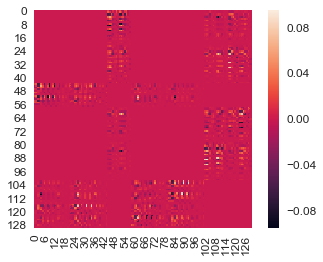

In [43]:
sns.heatmap(p_embedded_gwh_self_ovlp[0] - p_test[0], square=True)

In [44]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    density_from_fock_batch(fock_from_density_batch(p_embedded_gwh_self_ovlp)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 22:03:58: Iteration calculation: 0
[ ] 2019-01-07 22:04:02: Iteration calculation: 1
[ ] 2019-01-07 22:04:05: Iteration calculation: 2
[ ] 2019-01-07 22:04:08: Iteration calculation: 3
[ ] 2019-01-07 22:04:12: Iteration calculation: 4
[ ] 2019-01-07 22:04:16: Iteration calculation: 5
[ ] 2019-01-07 22:04:20: Iteration calculation: 6
[ ] 2019-01-07 22:04:23: Iteration calculation: 7
[ ] 2019-01-07 22:04:26: Iteration calculation: 8
[ ] 2019-01-07 22:04:29: Iteration calculation: 9
[ ] 2019-01-07 22:04:32: Iteration calculation: 10
[ ] 2019-01-07 22:04:37: Iteration calculation: 11
[ ] 2019-01-07 22:04:41: Iteration calculation: 12
[ ] 2019-01-07 22:04:44: Iteration calculation: 13
[ ] 2019-01-07 22:04:48: Iteration calculation: 14
[ ] 2019-01-07 22:04:51: Iteration calculation: 15
[ ] 2019-01-07 22:04:55: Iteration calculation: 16
[ ] 2019-01-07 22:04:58: Iteration calculation: 17
[ ] 2019-01-07 22:05:01: Iteration calculation: 18
[ ] 2019-01-07 22:05:05: Iteration calcul

[ ] 2019-01-07 22:14:50: Iteration calculation: 160
[ ] 2019-01-07 22:14:54: Iteration calculation: 161
[ ] 2019-01-07 22:14:58: Iteration calculation: 162
[ ] 2019-01-07 22:15:02: Iteration calculation: 163
[ ] 2019-01-07 22:15:05: Iteration calculation: 164
[ ] 2019-01-07 22:15:09: Iteration calculation: 165
[ ] 2019-01-07 22:15:12: Iteration calculation: 166
[ ] 2019-01-07 22:15:16: Iteration calculation: 167
[ ] 2019-01-07 22:15:20: Iteration calculation: 168
[ ] 2019-01-07 22:15:24: Iteration calculation: 169
[ ] 2019-01-07 22:15:27: Iteration calculation: 170
[ ] 2019-01-07 22:15:32: Iteration calculation: 171
[ ] 2019-01-07 22:15:36: Iteration calculation: 172
[ ] 2019-01-07 22:15:40: Iteration calculation: 173
[ ] 2019-01-07 22:15:45: Iteration calculation: 174
[ ] 2019-01-07 22:15:49: Iteration calculation: 175
[ ] 2019-01-07 22:15:52: Iteration calculation: 176
[ ] 2019-01-07 22:15:56: Iteration calculation: 177
[ ] 2019-01-07 22:16:00: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 22:25:33: Iteration calculation: 318
[ ] 2019-01-07 22:25:36: Iteration calculation: 319
[ ] 2019-01-07 22:25:40: Iteration calculation: 320
[ ] 2019-01-07 22:25:43: Iteration calculation: 321
[ ] 2019-01-07 22:25:47: Iteration calculation: 322
[ ] 2019-01-07 22:25:50: Iteration calculation: 323
[ ] 2019-01-07 22:25:54: Iteration calculation: 324
[ ] 2019-01-07 22:25:58: Iteration calculation: 325
[ ] 2019-01-07 22:26:01: Iteration calculation: 326
[ ] 2019-01-07 22:26:05: Iteration calculation: 327
[ ] 2019-01-07 22:26:09: Iteration calculation: 328
[ ] 2019-01-07 22:26:12: Iteration calculation: 329
[ ] 2019-01-07 22:26:16: Iteration calculation: 330
[ ] 2019-01-07 22:26:20: Iteration calculation: 331
[ ] 2019-01-07 22:26:24: Iteration calculation: 332
[ ] 2019-01-07 22:26:27: Iteration calculation: 333
[ ] 2019-01-07 22:26:31: Iteration calculation: 334
[ ] 2019-01-07 22:26:35: Iteration calculation: 335
[ ] 2019-01-07 22:26:39: Iteration calculation: 336
[ ] 2019-01-

In [45]:
6/(len(p_test))

0.014962593516209476

# Embedded GWH w/ OFF overlap

In [46]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask_off_overlap = np.zeros((dim, dim))

current_dim_i = 0
for i, atom_i in enumerate(mol.species):
    
    
    # calculate block range
    index_start_i = current_dim_i
    current_dim_i += N_BASIS[basis][atom_i] 
    index_end_i = current_dim_i
    
    # calculate logical vector
    L_i = np.arange(dim)
    L_i = np.logical_and(index_start_i <= L_i, L_i < index_end_i)
    
    current_dim_j = 0
    for j, atom_j in enumerate(mol.species):
        

        #print(str(i) + ", " + str(j))    
        #print(str(atom_i) + ", " + str(atom_j))
        
        # calculate block range
        index_start_j = current_dim_j
        current_dim_j += N_BASIS[basis][atom_j] 
        index_end_j = current_dim_j

        if i == j:
            continue
        
        if atom_i != atom_j:
            # calculate logical vector
            L_j = np.arange(dim)
            L_j = np.logical_and(index_start_j <= L_j, L_j < index_end_j)


            m = np.logical_and.outer(L_i, L_j)
            
            mask_off_overlap = np.logical_or(mask_off_overlap, m)
    
#mask

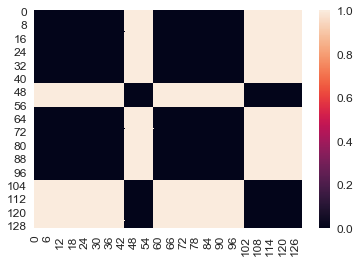

In [47]:
import seaborn as sns

sns.heatmap(mask_off_overlap.astype("int"))

In [48]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_off_ovlp(x, y):
    p = x.copy()
    p[mask_off_overlap] = (y.copy())[mask_off_overlap]
    return p

def embedd_batch_off_ovlp(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_off_ovlp(p_guess, p_conv))
    return np.array(p_embedded)


In [49]:
p_embedded_gwh_off_ovlp = embedd_batch_off_ovlp(p_embedded_gwh)

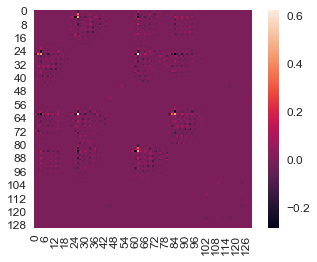

In [50]:
sns.heatmap(p_embedded_gwh_off_ovlp[0] - p_test[0], square=True)

In [51]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    density_from_fock_batch(fock_from_density_batch(p_embedded_gwh_off_ovlp)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 22:59:33: Iteration calculation: 0
[ ] 2019-01-07 22:59:36: Iteration calculation: 1
[ ] 2019-01-07 22:59:39: Iteration calculation: 2
[ ] 2019-01-07 22:59:42: Iteration calculation: 3
[ ] 2019-01-07 22:59:45: Iteration calculation: 4
[ ] 2019-01-07 22:59:48: Iteration calculation: 5
[ ] 2019-01-07 22:59:51: Iteration calculation: 6
[ ] 2019-01-07 22:59:54: Iteration calculation: 7
[ ] 2019-01-07 22:59:56: Iteration calculation: 8
[ ] 2019-01-07 22:59:59: Iteration calculation: 9
[ ] 2019-01-07 23:00:01: Iteration calculation: 10
[ ] 2019-01-07 23:00:03: Iteration calculation: 11
[ ] 2019-01-07 23:00:06: Iteration calculation: 12
[ ] 2019-01-07 23:00:10: Iteration calculation: 13
[ ] 2019-01-07 23:00:13: Iteration calculation: 14
[ ] 2019-01-07 23:00:16: Iteration calculation: 15
[ ] 2019-01-07 23:00:18: Iteration calculation: 16
[ ] 2019-01-07 23:00:20: Iteration calculation: 17
[ ] 2019-01-07 23:00:23: Iteration calculation: 18
[ ] 2019-01-07 23:00:25: Iteration calcul

[ ] 2019-01-07 23:08:20: Iteration calculation: 160
[ ] 2019-01-07 23:08:24: Iteration calculation: 161
[ ] 2019-01-07 23:08:28: Iteration calculation: 162
[ ] 2019-01-07 23:08:31: Iteration calculation: 163
[ ] 2019-01-07 23:08:34: Iteration calculation: 164
[ ] 2019-01-07 23:08:37: Iteration calculation: 165
[ ] 2019-01-07 23:08:41: Iteration calculation: 166
[ ] 2019-01-07 23:08:46: Iteration calculation: 167
[ ] 2019-01-07 23:08:49: Iteration calculation: 168
[ ] 2019-01-07 23:08:52: Iteration calculation: 169
[ ] 2019-01-07 23:08:54: Iteration calculation: 170
[ ] 2019-01-07 23:08:57: Iteration calculation: 171
[ ] 2019-01-07 23:08:59: Iteration calculation: 172
[ ] 2019-01-07 23:09:02: Iteration calculation: 173
[ ] 2019-01-07 23:09:05: Iteration calculation: 174
[ ] 2019-01-07 23:09:08: Iteration calculation: 175
[ ] 2019-01-07 23:09:12: Iteration calculation: 176
[ ] 2019-01-07 23:09:16: Iteration calculation: 177
[ ] 2019-01-07 23:09:19: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 23:16:54: Iteration calculation: 318
[ ] 2019-01-07 23:16:57: Iteration calculation: 319
[ ] 2019-01-07 23:17:00: Iteration calculation: 320
[ ] 2019-01-07 23:17:02: Iteration calculation: 321
[ ] 2019-01-07 23:17:05: Iteration calculation: 322
[ ] 2019-01-07 23:17:08: Iteration calculation: 323
[ ] 2019-01-07 23:17:13: Iteration calculation: 324
[ ] 2019-01-07 23:17:17: Iteration calculation: 325
[ ] 2019-01-07 23:17:20: Iteration calculation: 326
[ ] 2019-01-07 23:17:23: Iteration calculation: 327
[ ] 2019-01-07 23:17:26: Iteration calculation: 328
[ ] 2019-01-07 23:17:30: Iteration calculation: 329
[ ] 2019-01-07 23:17:34: Iteration calculation: 330
[ ] 2019-01-07 23:17:37: Iteration calculation: 331
[ ] 2019-01-07 23:17:40: Iteration calculation: 332
[ ] 2019-01-07 23:17:43: Iteration calculation: 333
[ ] 2019-01-07 23:17:45: Iteration calculation: 334
[ ] 2019-01-07 23:17:48: Iteration calculation: 335
[ ] 2019-01-07 23:17:53: Iteration calculation: 336
[ ] 2019-01-

In [52]:
7/len(p_test)

0.017456359102244388